In [211]:
#simple neural network

import numpy as np
import matplotlib.pyplot as plt

class NeuralNet():
    def __init__(self, num_input, num_hidden, num_output, backprop='standard'):
        """
        Initialize weights and biases.
        """
        self.W1 = np.random.rand(num_hidden, num_input) / np.sqrt(num_input)
        self.b1 = np.zeros((num_hidden, 1))
        
        self.W2 = np.random.rand(num_hidden, num_hidden) / np.sqrt(num_hidden)
        self.b2 = np.zeros((num_hidden, 1))
        
        self.W3 = np.random.rand(num_output, num_hidden) / np.sqrt(num_output)
        self.b3 = np.zeros((num_output, 1))
        
        self.backprop = backprop
        
        #FA paper initialises weights uniformly between -0.5 and 0.5
        if self.backprop == 'fa':
            self.B2 = np.random.uniform(-0.5,0.5,(self.W3.T).shape)
            self.B1 = np.random.uniform(-0.5,0.5,(self.W2.T).shape)
            
        elif self.backprop == 'dfa' or backprop == 'ifa':
            self.B2 = np.random.uniform(-0.5,0.5,(self.W3.T).shape)
            self.B1 = np.random.uniform(-0.5,0.5,(self.W2.T).shape)
            
            #supposed to initialise uniformly between +/- 1/sqrt(fan out) for dfa or ifa
            #but i found uniformly initialising between +/- 0.5 worked better for some reason
            #self.B2 = np.random.uniform(-1/np.sqrt(self.W3.shape[0]),1/np.sqrt(self.W3.shape[0]),(self.W3.T).shape)
            #self.B1 = np.random.uniform(-1/np.sqrt(self.W2.shape[0]),1/np.sqrt(self.W2.shape[0]),(self.W2.T).shape)
    
    def softmax(self,x):
        """
        Softmax functions for converting real numbered outputs into a probability distribution.
        """
        #generate probabilities
        probs = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)
        return probs
    
    def d_tanh(self, x):
        """
        Derivative of the tanh activation (non-linear) function, which is (1-tanh(x)^2)
        """
        derivative = (1 - np.square(np.tanh(x)))
        return derivative
    
    def forward_pass(self, X):
        """
        Passes data, X, through the neural network.
        """
        #input = X
        #z = weighted sum of inputs
        #a = weighted sum of inputs passed through 'activation' non-linearity function
                
        z1 = np.dot(self.W1, X) + self.b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(self.W2, a1) + self.b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(self.W3, a2) + self.b3
        a3 = self.softmax(z3)
            
        return z1, z2, z3, a1, a2, a3
    
    def predict(self, X):
        """
        Get a prediction from the network by taking the most likely value from the probability distribution.
        """
        
        _, _, _, _, _, a3 = self.forward_pass(X)

        return np.argmax(a3, axis=1)
    
    def cross_entropy_loss(self, X, y):
        """
        Calculates loss via cross entropy (for single-class) or negative log likelihood (for multi-class).
        """
        
        #numputer of input samples
        num_data = len(X)
        
        #get probabilities
        _, _, _, _, _, a3 = self.forward_pass(X)
        
        #convert to negative log probabilities
        logprob = -np.log(a3[range(num_data),y])
        
        #sum all log probabilities
        loss = np.sum(logprob)

        return loss
    
    def backpropagation(self, X, y, lr):
        """
        Updates the weights of the network by calculating the error and updating the weights (W1, W2, W3)
        and biases (b1, b2, b3) in proportion to how much they contributed to the error (contribution found by
        calculating the gradients).
        """
        
        z1, z2, z3, a1, a2, a3 = self.forward_pass(X)

        #get deltas
        d3 = a3
        d3[y] -= 1
        d2 = np.dot(self.W3.T, d3) * self.d_tanh(z2)
        d1 = np.dot(self.W2.T, d2) * self.d_tanh(z1)
        
        #partial derivatives
        #dW3 = a2.T.dot(d3)
        #db3 = np.sum(d3, axis=0, keepdims=True)
        #dW2 = a1.T.dot(d2)
        #db2 = np.sum(d2, axis=0, keepdims=True)
        #dW1 = X.T.dot(d1)
        #db1 = np.sum(d1, axis=0, keepdims=True)

        #gradient descent for whole batch
        self.W3 += -lr * np.dot(d3, a2.T)
        self.b3 += -lr * np.sum(d3, axis=1, keepdims=True)
        self.W2 += -lr * np.dot(d2, a1.T)
        self.b2 += -lr * np.sum(d2, axis=1, keepdims=True)
        print(d1.shape)
        print(X.T.shape)
        self.W1 += -lr * np.dot(d1, X.T)
        self.b1 += -lr * np.sum(d1, axis=1, keepdims=True)
    
    def feedback_alignment(self, X, y, lr):
        
        num_data = len(X)
        z1, z2, z3, a1, a2, a3 = self.forward_pass(X)

        #get deltas
        d3 = a3
        d3[range(num_data),y] -= 1
        
        """
        These two lines are the only one that change from standard backprop!
        Feedback alignment doesn't use weight matrices (W), but fixed random matrices (B)
        """
        
        d2 = np.matmul(d3, self.B2) * self.d_tanh(z2)
        d1 = np.matmul(d2, self.B1) * self.d_tanh(z1)

        #partial derivatives
        #dW3 = a2.T.dot(d3)
        #db3 = np.sum(d3, axis=0, keepdims=True)
        #dW2 = a1.T.dot(d2)
        #db2 = np.sum(d2, axis=0, keepdims=True)
        #dW1 = X.T.dot(d1)
        #db1 = np.sum(d1, axis=0, keepdims=True)

        #gradient descent for whole batch
        self.W3 += -lr * np.matmul(a2.T, d3)
        self.b3 += -lr * np.sum(d3, axis=0, keepdims=True)
        self.W2 += -lr * np.matmul(a1.T, d2)
        self.b2 += -lr * np.sum(d2, axis=0, keepdims=True)
        self.W1 += -lr * np.matmul(X.T, d1)
        self.b1 += -lr * np.sum(d1, axis=0, keepdims=True)
        
    def direct_feedback_alignment(self, X, y, lr):
        
        num_data = len(X)
        z1, z2, z3, a1, a2, a3 = self.forward_pass(X)

        #get deltas
        d3 = a3
        d3[range(num_data),y] -= 1
        
        """
        These two lines are the only one that change from standard backprop!
        Doesn't depend on gradient from other layers, only gradient from last layer
        """
        
        d2 = np.matmul(d3, self.B2) * self.d_tanh(z2)
        d1 = np.matmul(d3, self.B1) * self.d_tanh(z1)

        #partial derivatives
        #dW3 = a2.T.dot(d3)
        #db3 = np.sum(d3, axis=0, keepdims=True)
        #dW2 = a1.T.dot(d2)
        #db2 = np.sum(d2, axis=0, keepdims=True)
        #dW1 = X.T.dot(d1)
        #db1 = np.sum(d1, axis=0, keepdims=True)

        #gradient descent for whole batch
        self.W3 += -lr * np.matmul(a2.T, d3)
        self.b3 += -lr * np.sum(d3, axis=0, keepdims=True)
        self.W2 += -lr * np.matmul(a1.T, d2)
        self.b2 += -lr * np.sum(d2, axis=0, keepdims=True)
        self.W1 += -lr * np.matmul(X.T, d1)
        self.b1 += -lr * np.sum(d1, axis=0, keepdims=True)
    
    def indirect_feedback_alignment(self, X, y, lr):
        
        num_data = len(X)
        z1, z2, z3, a1, a2, a3 = self.forward_pass(X)

        #get deltas
        d3 = a3
        d3[range(num_data),y] -= 1
        
        """
        These two lines are the only one that change from standard backprop!
        Use both W and B and also train from front to back
        """
        
        d1 = np.matmul(d3, self.B2) * self.d_tanh(z1)
        d2 = np.matmul(d1, self.W2)* self.d_tanh(z2)

        #partial derivatives
        #dW3 = a2.T.dot(d3)
        #db3 = np.sum(d3, axis=0, keepdims=True)
        #dW2 = a1.T.dot(d2)
        #db2 = np.sum(d2, axis=0, keepdims=True)
        #dW1 = X.T.dot(d1)
        #db1 = np.sum(d1, axis=0, keepdims=True)

        #gradient descent for whole batch
        self.W3 += -lr * np.matmul(a2.T, d3)
        self.b3 += -lr * np.sum(d3, axis=0, keepdims=True)
        self.W2 += -lr * np.matmul(a1.T, d2)
        self.b2 += -lr * np.sum(d2, axis=0, keepdims=True)
        self.W1 += -lr * np.matmul(X.T, d1)
        self.b1 += -lr * np.sum(d1, axis=0, keepdims=True)
    
    def train(self, X, y, lr, N, log=False, backprop='standard'):
        """
        Train for N steps, each step is a whole epoch, i.e. all of the training data.
        'lr' is the learning rate, the scale of the weight updates.
        """
        for i in range(0, N):
            
            for input, label in zip(X, y):
            
                input = input.reshape((input.shape[0], 1))
            
                if self.backprop == 'fa':
                    self.feedback_alignment(input, label, lr)

                elif self.backprop == 'dfa':
                    self.direct_feedback_alignment(input, label, lr)

                elif self.backprop == 'ifa':
                    self.indirect_feedback_alignment(input, label, lr)

                else:
                    self.backpropagation(input, label, lr)
                  
    def visualize_preds(self, X, y):
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - 0.7, X[:, 0].max() + 0.7
        y_min, y_max = X[:, 1].min() - 0.7, X[:, 1].max() + 0.7
        # Space between grid points
        h = 0.005
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        # Predict values for whole gid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        # print Z.shape
        Z = Z.reshape(xx.shape)
        # Plot the contour
        plt.figure(figsize=(7, 5))
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.show()

In [212]:
#generate data 
import sklearn.datasets

X1, y1 = sklearn.datasets.make_moons(500, noise=0.2, random_state=1)
X2, y2 = sklearn.datasets.make_circles(n_samples=500, noise=0.2, factor=0.005, random_state=1)

In [213]:
#define neural networks
net1 = NeuralNet(2, 100, 2)
net2 = NeuralNet(2, 100, 2)

fa_net1 = NeuralNet(2, 100, 2, backprop='fa')
fa_net2 = NeuralNet(2, 100, 2, backprop='fa')

dfa_net1 = NeuralNet(2, 100, 2, backprop='dfa')
dfa_net2 = NeuralNet(2, 100, 2, backprop='dfa')

ifa_net1 = NeuralNet(2, 100, 2, backprop='ifa')
ifa_net2 = NeuralNet(2, 100, 2, backprop='ifa')

# Standard Backprop

In [214]:
#train neural network
net1.train(X1, y1, 0.001, 1000)
print("loss: {}".format(net1.cross_entropy_loss(X1, y1)))
net1.visualize_preds(X1,y1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)
(1, 2)
(100, 1)

KeyboardInterrupt: 

loss: 1.603217312770844


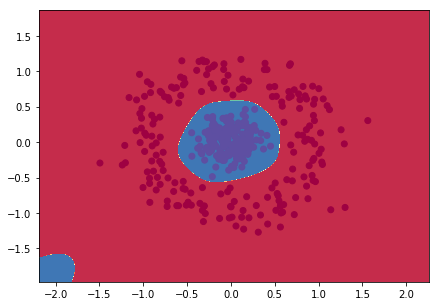

In [5]:
#train neural network
net2.train(X2, y2, 0.001, 1000)
print("loss: {}".format(net2.cross_entropy_loss(X2, y2)))
net2.visualize_preds(X2,y2)

# Feedback Alignment

loss: 13.500028218870455


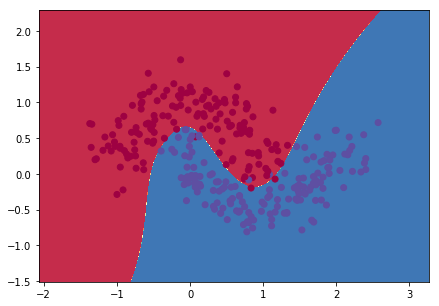

In [6]:
#train neural network
fa_net1.train(X1, y1, 0.001, 1000)
print("loss: {}".format(fa_net1.cross_entropy_loss(X1, y1)))
fa_net1.visualize_preds(X1,y1)

loss: 2.178588442059838


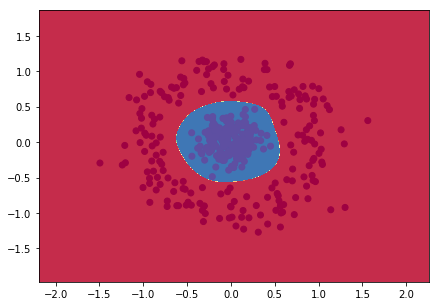

In [7]:
#train neural network
fa_net2.train(X2, y2, 0.001, 1000)
print("loss: {}".format(fa_net2.cross_entropy_loss(X2, y2)))
fa_net2.visualize_preds(X2,y2)

# Direct Feedback Alignment

loss: 13.338737656077475


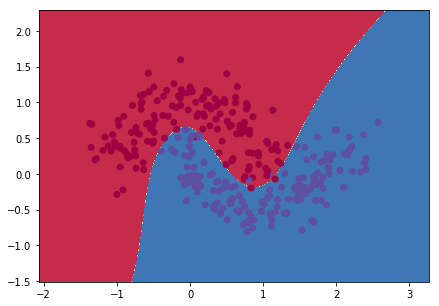

In [8]:
#train neural network
dfa_net1.train(X1, y1, 0.001, 1000)
print("loss: {}".format(dfa_net1.cross_entropy_loss(X1, y1)))
dfa_net1.visualize_preds(X1,y1)

loss: 0.3670935525816799


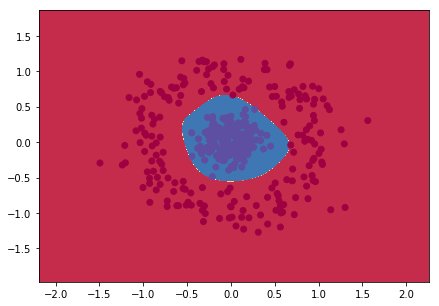

In [9]:
#train neural network
dfa_net2.train(X2, y2, 0.01, 1000)
print("loss: {}".format(dfa_net2.cross_entropy_loss(X2, y2)))
dfa_net2.visualize_preds(X2,y2)

# Indirect Feedback Alignment

loss: 19.6901631357232


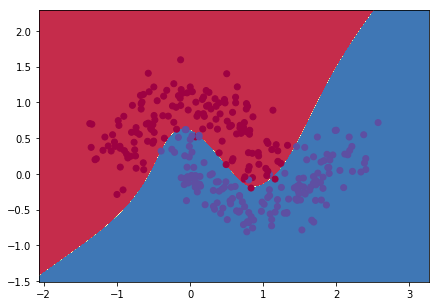

In [10]:
#train neural network
ifa_net1.train(X1, y1, 0.001, 1000)
print("loss: {}".format(ifa_net1.cross_entropy_loss(X1, y1)))
ifa_net1.visualize_preds(X1,y1)

loss: 0.7727279897488439


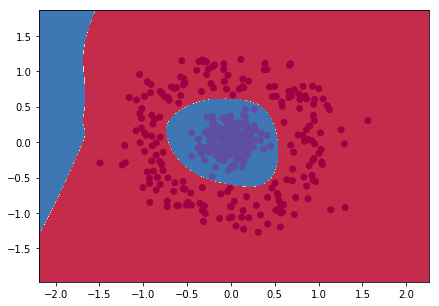

In [11]:
#train neural network
ifa_net2.train(X2, y2, 0.001, 1000)
print("loss: {}".format(ifa_net2.cross_entropy_loss(X2, y2)))
ifa_net2.visualize_preds(X2,y2)